In [1]:
import tensorflow as tf

# Defina o caminho para a pasta que contém as imagens
data_dir = 'data_cancer'

# Carregue as imagens da pasta
batch_size = 32
img_height = 180
img_width = 180

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

# Normalização das imagens
normalization_layer = tf.keras.layers.Rescaling(1./255)

normalized_train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
normalized_val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

# Verifique o formato dos dados
for image_batch, labels_batch in normalized_train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

Found 7023 files belonging to 4 classes.
Using 5619 files for training.
Found 7023 files belonging to 4 classes.
Using 1404 files for validation.
(32, 180, 180, 3)
(32,)


In [3]:
class_names = train_ds.class_names
print(class_names)

['glioma', 'healthy', 'meningioma', 'pituitary']


In [4]:
# Definir o modelo
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(len(class_names), activation='softmax')
])

# Compilar o modelo
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

# Treinar o modelo
history = model.fit(
    normalized_train_ds,
    validation_data=normalized_val_ds,
    epochs=10
)

# Avaliar o modelo
loss, accuracy = model.evaluate(normalized_val_ds)
print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

Epoch 1/10
176/176 [==============================] - 13s 40ms/step - loss: 0.6458 - accuracy: 0.7435 - val_loss: 0.4058 - val_accuracy: 0.8476
Epoch 2/10
176/176 [==============================] - 6s 36ms/step - loss: 0.2929 - accuracy: 0.8872 - val_loss: 0.2653 - val_accuracy: 0.9081
Epoch 3/10
176/176 [==============================] - 6s 36ms/step - loss: 0.1691 - accuracy: 0.9407 - val_loss: 0.2295 - val_accuracy: 0.9245
Epoch 4/10
176/176 [==============================] - 6s 35ms/step - loss: 0.0817 - accuracy: 0.9733 - val_loss: 0.2035 - val_accuracy: 0.9402
Epoch 5/10
176/176 [==============================] - 6s 35ms/step - loss: 0.0435 - accuracy: 0.9843 - val_loss: 0.1879 - val_accuracy: 0.9480
Epoch 6/10
176/176 [==============================] - 6s 36ms/step - loss: 0.0379 - accuracy: 0.9883 - val_loss: 0.2565 - val_accuracy: 0.9281
Epoch 7/10
176/176 [==============================] - 6s 35ms/step - loss: 0.0278 - accuracy: 0.9913 - val_loss: 0.3088 - val_accuracy: 0.918

1/1 [==============================] - 0s 20ms/step


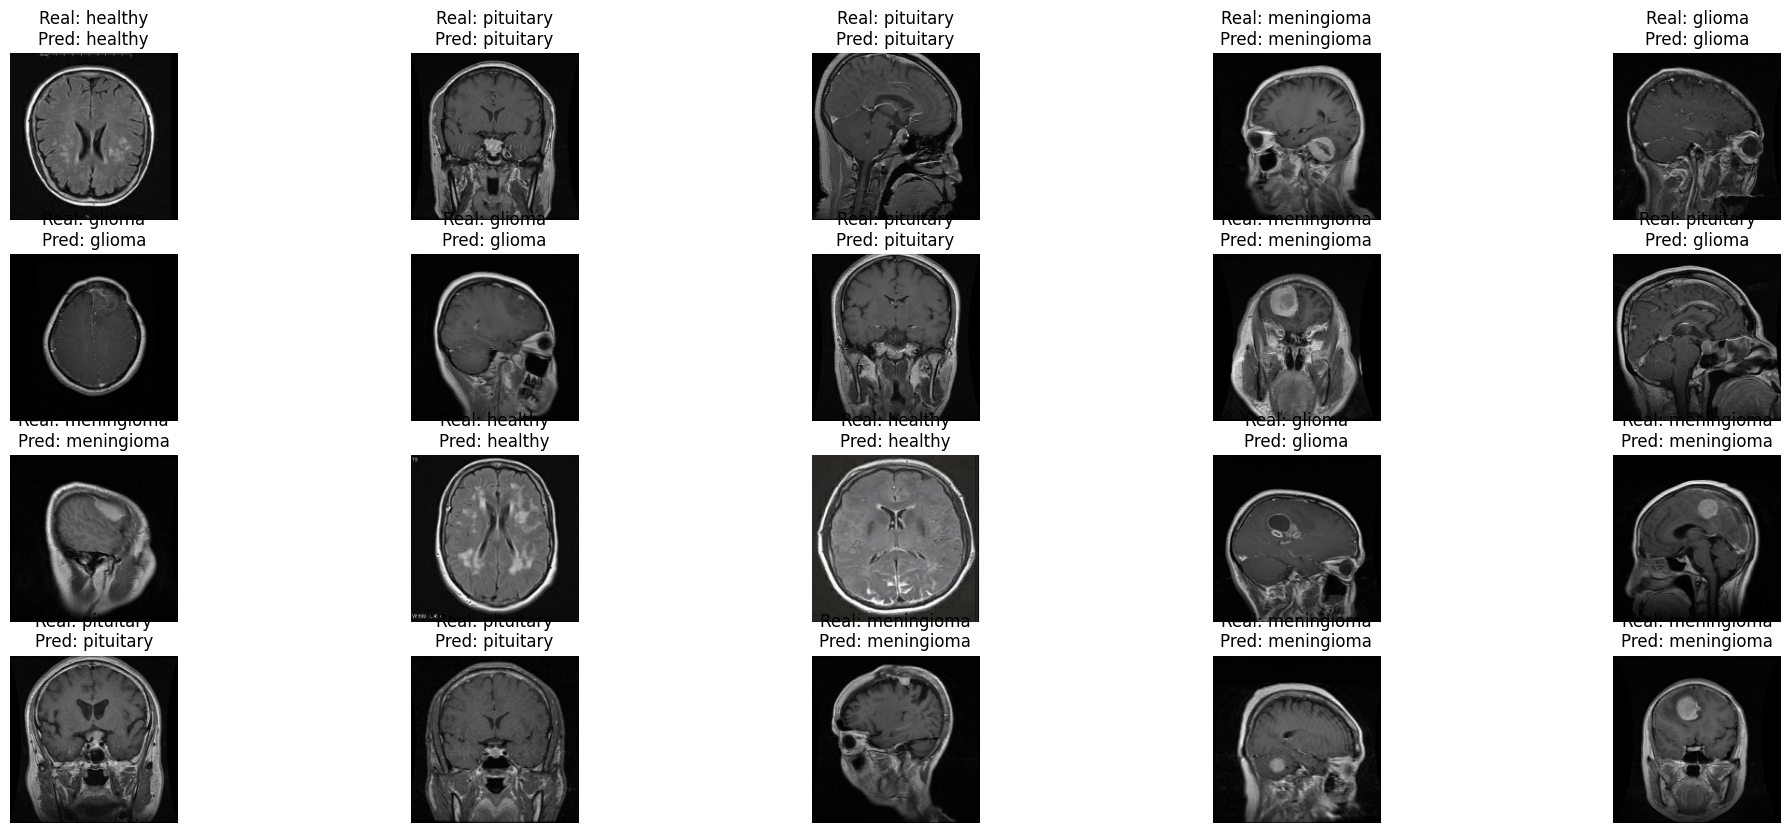

In [6]:
import matplotlib.pyplot as plt

# Obter as primeiras 20 imagens e seus rótulos do conjunto de validação
for images, labels in normalized_val_ds.take(1):
    images = images[:20]
    labels = labels[:20]

# Fazer previsões
predictions = model.predict(images)
predicted_labels = tf.argmax(predictions, axis=1)

# Plotar as imagens com suas previsões
plt.figure(figsize=(25, 10))
for i in range(20):
    ax = plt.subplot(4, 5, i + 1)
    plt.imshow(images[i].numpy())
    plt.title(f"Real: {class_names[labels[i]]}\nPred: {class_names[predicted_labels[i]]}")
    plt.axis("off")
plt.show()

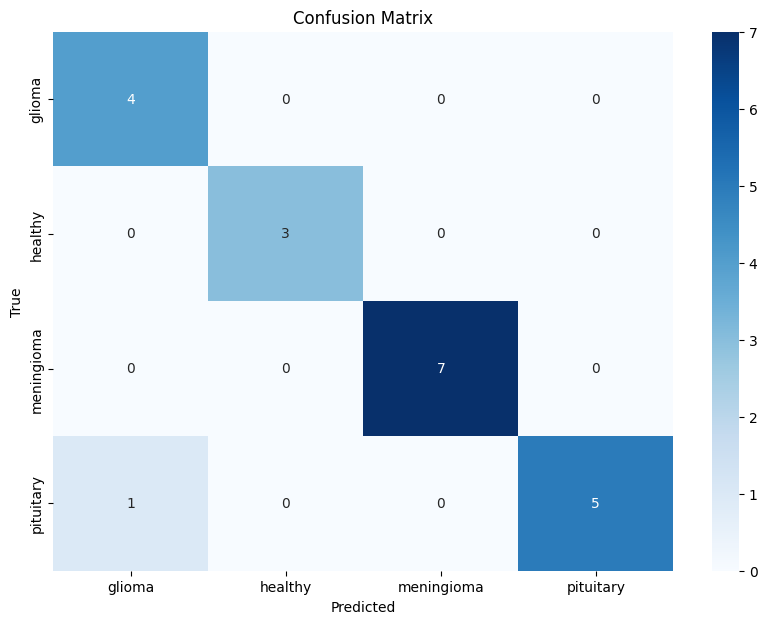

In [9]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Calcular a matriz de confusão
cm = confusion_matrix(labels, predicted_labels)

# Plotar a matriz de confusão
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

1/1 [==============================] - 0s 16ms/step


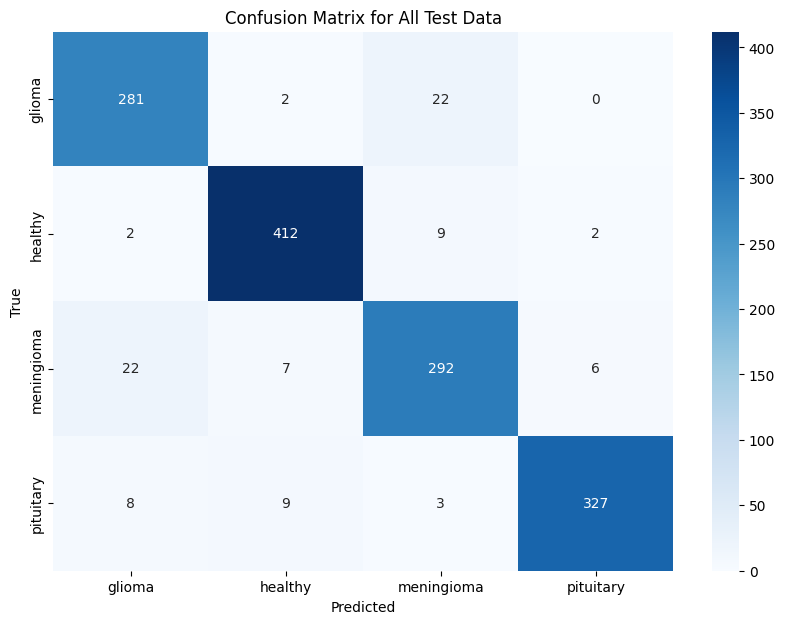

In [10]:
# Obter todas as imagens e rótulos do conjunto de validação
all_labels = []
all_predictions = []

for images, labels in normalized_val_ds:
    predictions = model.predict(images)
    predicted_labels = tf.argmax(predictions, axis=1)
    all_labels.extend(labels.numpy())
    all_predictions.extend(predicted_labels.numpy())

# Calcular a matriz de confusão
cm_all = confusion_matrix(all_labels, all_predictions)

# Plotar a matriz de confusão
plt.figure(figsize=(10, 7))
sns.heatmap(cm_all, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for All Test Data')
plt.show()

In [11]:
teste_dir = 'meningioma.jpeg'
from tensorflow.keras.preprocessing import image
import numpy as np

# Carregar a imagem
img = image.load_img(teste_dir, target_size=(img_height, img_width))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = normalization_layer(img_array)

# Fazer a previsão
predictions = model.predict(img_array)
predicted_class = class_names[np.argmax(predictions)]

print(f"A imagem foi classificada como: {predicted_class}")


1/1 [==============================] - 0s 267ms/step
A imagem foi classificada como: meningioma


In [12]:
predictions

array([[5.781611e-06, 3.554570e-04, 9.988953e-01, 7.433853e-04]],
      dtype=float32)

In [14]:
teste_dir = 'Pituitary.jpg'
from tensorflow.keras.preprocessing import image
import numpy as np

# Carregar a imagem
img = image.load_img(teste_dir, target_size=(img_height, img_width))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = normalization_layer(img_array)

# Fazer a previsão
predictions = model.predict(img_array)
predicted_class = class_names[np.argmax(predictions)]

print(f"A imagem foi classificada como: {predicted_class}")

1/1 [==============================] - 0s 15ms/step
A imagem foi classificada como: meningioma


In [15]:
teste_dir = 'glioma.jpg'
from tensorflow.keras.preprocessing import image
import numpy as np

# Carregar a imagem
img = image.load_img(teste_dir, target_size=(img_height, img_width))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = normalization_layer(img_array)

# Fazer a previsão
predictions = model.predict(img_array)
predicted_class = class_names[np.argmax(predictions)]

print(f"A imagem foi classificada como: {predicted_class}")

1/1 [==============================] - 0s 12ms/step
A imagem foi classificada como: healthy
